In [165]:
## import modules
import sys
from collections import OrderedDict
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from captum.attr import LRP, IntegratedGradients as IG
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange
from scipy import stats

sys.path.append('../')

from pytorch_utils.data_pipeline import TSData

## Data loader for a sequential model

* For the training loader, we use a window size of 100 time steps from the range 1980-01-01 to 2000-12-31
* For the validation loader, we use the entire sequence 2001-01-01 to 2020-12-31

In [30]:
## some settings
LCT = 'MF'  # land cover type
norm_kind = 'mean_std'  # min_max
deseasonalize = False
target_var = 'GPP_constant-VPD'

In [31]:
## load data from csv to Xarray dataset
df = pd.read_csv('../simple_gpp_model/data/predictor-variables+GPP_Jena_' + LCT + '.csv', index_col=0, parse_dates=True)

if deseasonalize:
    df = df.groupby(by=df.index.dayofyear).transform(lambda x: x - x.mean())

ds = df.to_xarray().rename({'index': 'time'})
ds = ds.sel(time=slice('1982-01-15', None))  # FAPAR is NaN the first two weeks

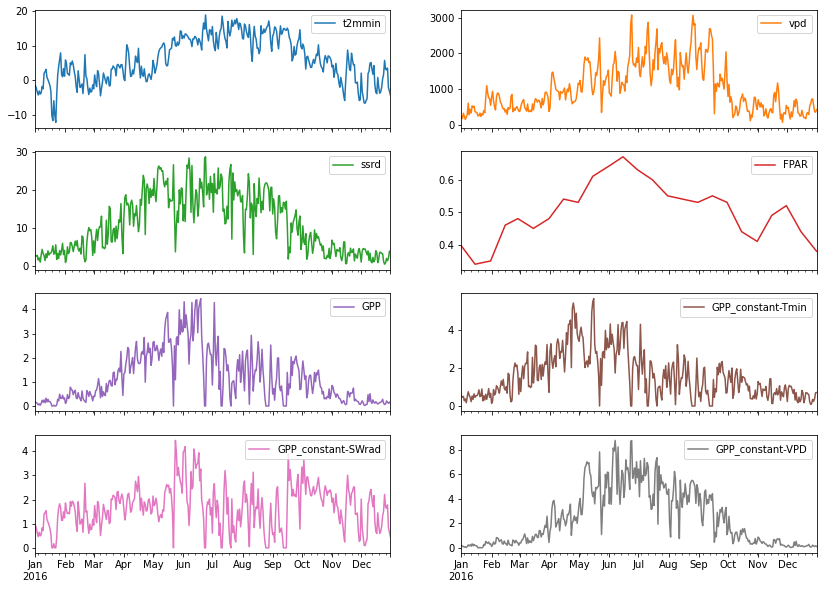

In [32]:
variables = ['t2mmin', 'vpd', 'ssrd', 'FPAR', 'GPP', 'GPP_constant-Tmin', 'GPP_constant-SWrad', 'GPP_constant-VPD']
df.loc['2016'][variables].plot(subplots=True, layout=(4, 2), figsize=(14, 10), ax=None)
plt.show()

In [33]:
train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets=target_var, time_slice=slice('1982', '2000'),
           #normalize=False,
           norm_kind=norm_kind,
           ),
    batch_size=50,
    shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets=target_var, time_slice=slice('2001', '2016'),
           #normalize=False,
           norm_kind=norm_kind,
           return_seq=True,
           ts_window_size=-1,
           norm_stats=train_loader.dataset.norm_stats
           ),
    batch_size=1,
    shuffle=False)

In [34]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)

    if i > 3:
        break


torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])
torch.Size([50, 4]) torch.Size([50, 1])


In [84]:

from captum.attr._utils.lrp_rules import IdentityRule
from captum.attr._core.lrp import SUPPORTED_NON_LINEAR_LAYERS

for nl in [nn.Sigmoid, nn.Identity]:
    if nl in SUPPORTED_NON_LINEAR_LAYERS:
        continue

    SUPPORTED_NON_LINEAR_LAYERS.append(nl)

ACTIVATIONS = {'relu': nn.ReLU,
               'sigmoid': nn.Sigmoid,
               'tanh': nn.Tanh,
               'identity': nn.Identity}


@dataclass(unsafe_hash=True)
class FCNLayer(nn.Module):
    in_features: int
    out_features: int
    activation: str = 'sigmoid'
    dropout_rate: float = 0.0

    def __post_init__(self):
        super(FCNLayer, self).__init__()
        self.fc = nn.Linear(self.in_features, self.out_features)
        self.dropout = nn.Dropout(self.dropout_rate) if self.dropout_rate > 0.0 else None
        self.activation_fcn = ACTIVATIONS[self.activation]()

    def forward(self, x):
        x = self.fc(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.activation_fcn(x)
        return x


class FCN(nn.Module):
    def __init__(
            self,
            num_feature: int,
            num_targets: int = 1,
            num_hidden: int = 8,
            num_layers: int = 2,
            dropout: float = 0.0,
            activation: str = 'sigmoid',
            output_activation: str = 'identity',
            learning_rate: float = 0.001,
            weight_decay: float = 0.0) -> None:

        """A fully connected feed-forward model.
        
        Parameters
        -----------
        num_features: int
            The number of input features.
        num_targets: int (default is 1)
            The number of targets.
        num_hidden: int (default is 8)
            The number of hidden nodes per layer.
        num_layers: int (default is 2)
            The number of hidden nodes.
        dropout: float (default is 0.0)
            The dropout used in all hidden layers.
        activation: str (default is sigmoid)
            The activation function.
        output_activation: str (default is identity)
            The output activation function, default is nn.Identity and does not transform the output.
        learning_rate: float (default is 0.001):
            The learning rate.
        weight_decay: float (default is 0.0)
            The weight decay (L2 regularization).
        """
        super(FCN, self).__init__()
        self.valid_losses = None
        self.train_losses = None

        layers = OrderedDict()
        in_sizes = [num_feature] + [num_hidden] * num_layers
        out_sizes = [num_hidden] * num_layers + [num_targets]

        for i, (nin, nout) in enumerate(zip(in_sizes, out_sizes)):
            is_input_layer = i == 0
            is_output_layer = i == num_layers

            if not is_input_layer and not is_output_layer:
                dropout_rate = dropout
            else:
                dropout_rate = 0.0

            nl = output_activation if is_output_layer else activation
            layer = FCNLayer(in_features=nin, out_features=nout, dropout_rate=dropout_rate, activation=nl)

            layers.update({f'layer{i}': layer})

        self.model = nn.Sequential(layers)

        self.optimizer = self.get_optimizer(self.model.parameters(), learning_rate=learning_rate,
                                            weight_decay=weight_decay)

        #@todo: add scaling by target magnitude to increase preformance for high values (Albrecht's idea)
        self.loss_fn = F.mse_loss

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> Tensor:
        self.train()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in tqdm(train_loader, leave=False, desc='training step'):
            self.optimizer.zero_grad()

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            self.optimizer.step()

            loss_sum += loss.item()
            loss_counter += 1

        return (loss_sum / loss_counter).item()

    @torch.no_grad()
    def eval_epoch(self, valid_loader: torch.utils.data.DataLoader) -> Tensor:
        self.eval()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in tqdm(valid_loader, leave=False, desc='validation step'):
            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)

        loss_sum += loss.item()
        loss_counter += 1

        return (loss_sum / loss_counter).item()

    def tune(self, num_epochs: int, train_loader: torch.utils.data.DataLoader,
             valid_loader: torch.utils.data.DataLoader) -> None:
        self.train_losses = np.zeros(num_epochs)
        self.valid_losses = np.zeros(num_epochs)

        train_loss = -1
        valid_loss = -1
        pbar = trange(num_epochs)
        for epoch in pbar:
            pbar.set_description(f'train loss: {train_loss}, valid loss: {valid_loss}')

            train_loss = self.train_epoch(train_loader=train_loader)
            valid_loss = self.eval_epoch(valid_loader=valid_loader)

            self.train_losses[epoch] = train_loss
            self.valid_losses[epoch] = valid_loss

    def get_optimizer(self, params: torch.ParameterDict, learning_rate: float = 0.001,
                      weight_decay: float = 0.0) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)


## We can iterate the data in batches of size 50

In [85]:
model = FCN(num_feature=4, learning_rate=0.1, activation='sigmoid', output_activation='identity')

In [142]:
model.tune(num_epochs=10, train_loader=train_loader, valid_loader=valid_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

training step:   0%|          | 0/139 [00:00<?, ?it/s]

validation step:   0%|          | 0/1 [00:00<?, ?it/s]

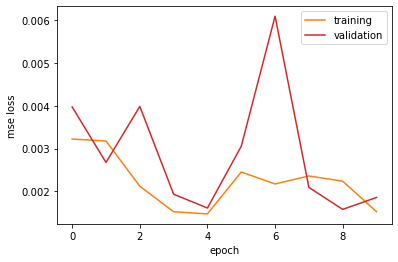

In [143]:
plt.plot(model.train_losses, label='training', color='tab:orange')
plt.plot(model.valid_losses, label='validation', color='tab:red')

plt.xlabel('epoch')
plt.ylabel('mse loss')

plt.legend()
plt.show()

### Make plot to see preformance

In [144]:
predictor, target = next(iter(train_loader))
target = target.detach().numpy()

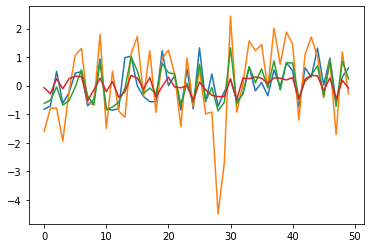

In [145]:
plt.figure()
plt.plot(predictor.detach().numpy())
plt.show()

In [146]:
target_pred = model(predictor).detach().numpy()

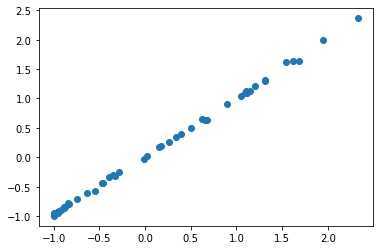

In [147]:
plt.scatter(target, target_pred)
plt.show()

### Attribution

In [148]:
prediction_data_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['ssrd', 't2mmin', 'vpd', 'FPAR'], targets=target_var, time_slice=slice('1982', '2016'),
           #normalize=False,
           norm_kind=norm_kind,
           norm_stats=train_loader.dataset.norm_stats
           ),
    batch_size=12770,
    shuffle=False)

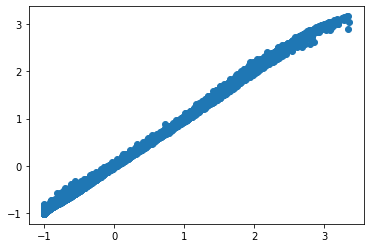

In [149]:
predictor, target = next(iter(prediction_data_loader))

target = target.detach().numpy()
target_pred = model(predictor).detach().numpy()
plt.scatter(target, target_pred)
plt.show()

In [150]:
target = prediction_data_loader.dataset.denorm_np(target.squeeze(), target_var)
target_pred = prediction_data_loader.dataset.denorm_np(target_pred.squeeze(), target_var)

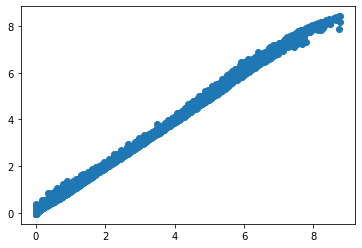

In [151]:
plt.scatter(target, target_pred)
plt.show()

In [152]:
df = ds.to_dataframe()

In [153]:
df['GPP_pred'] = target_pred

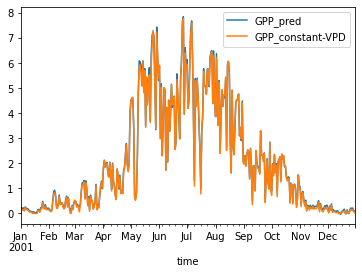

In [154]:
df.loc['2001'][['GPP_pred', target_var]].plot()
plt.show()

In [155]:
def compute_integrated_gradient(batch_x, batch_blank, model):
    mean_grad = 0
    n = 100

    for i in range(1, n + 1):
        x = batch_blank + i / n * (batch_x - batch_blank)
        x.requires_grad = True
        y = model(x)
        (grad,) = torch.autograd.grad(y, x)
        mean_grad += grad / n

    integrated_gradients = (batch_x - batch_blank) * mean_grad

    return integrated_gradients, mean_grad

In [156]:
batch_x, batch_y = next(iter(valid_loader))

In [157]:
batch_y_hat = model(batch_x)

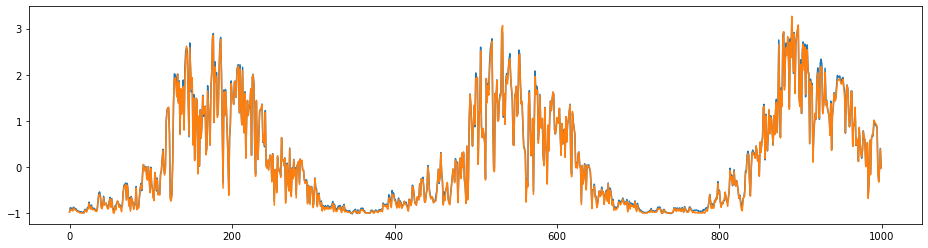

In [158]:
plt.figure(figsize=(16, 4))
plt.plot(batch_y_hat.detach().numpy().squeeze()[:1000])
plt.plot(batch_y.detach().numpy().squeeze()[:1000])
plt.show()

In [159]:
batch_x_bl = torch.zeros_like(batch_x)
##@todo: add normalization of zeros based on predictor normalization - probably does not play a big role here

In [160]:
n = batch_x.shape[1]
intgrads = np.empty((n, 4), dtype=np.float32)

In [161]:
lrp = LRP(model)

lrp_list = list()
for i in trange(n):
    x = batch_x[0, i, :]
    intgrds = compute_integrated_gradient(x, batch_x_bl[0, i, :], model)
    it, mn = intgrds
    intgrads[i, :] = it

    x.requires_grad = True
    lrp_list += [lrp.attribute(x.unsqueeze(0), verbose=False)]
lrp_attr = torch.cat(lrp_list).detach().numpy()

  0%|          | 0/5844 [00:00<?, ?it/s]

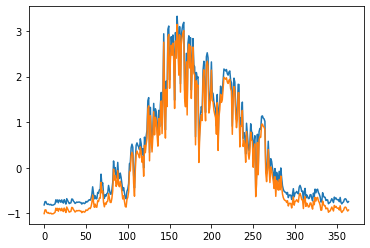

In [167]:
nth_year = 2
year_slice = slice(nth_year * 365, (nth_year + 1) * 365)

plt.plot(intgrads[year_slice, :].sum(axis=1))
plt.plot(batch_y_hat.detach().squeeze()[year_slice])
plt.show()

In [254]:
lrp_attr_z = lrp_attr / np.abs(lrp_attr).mean(1)[:, np.newaxis]

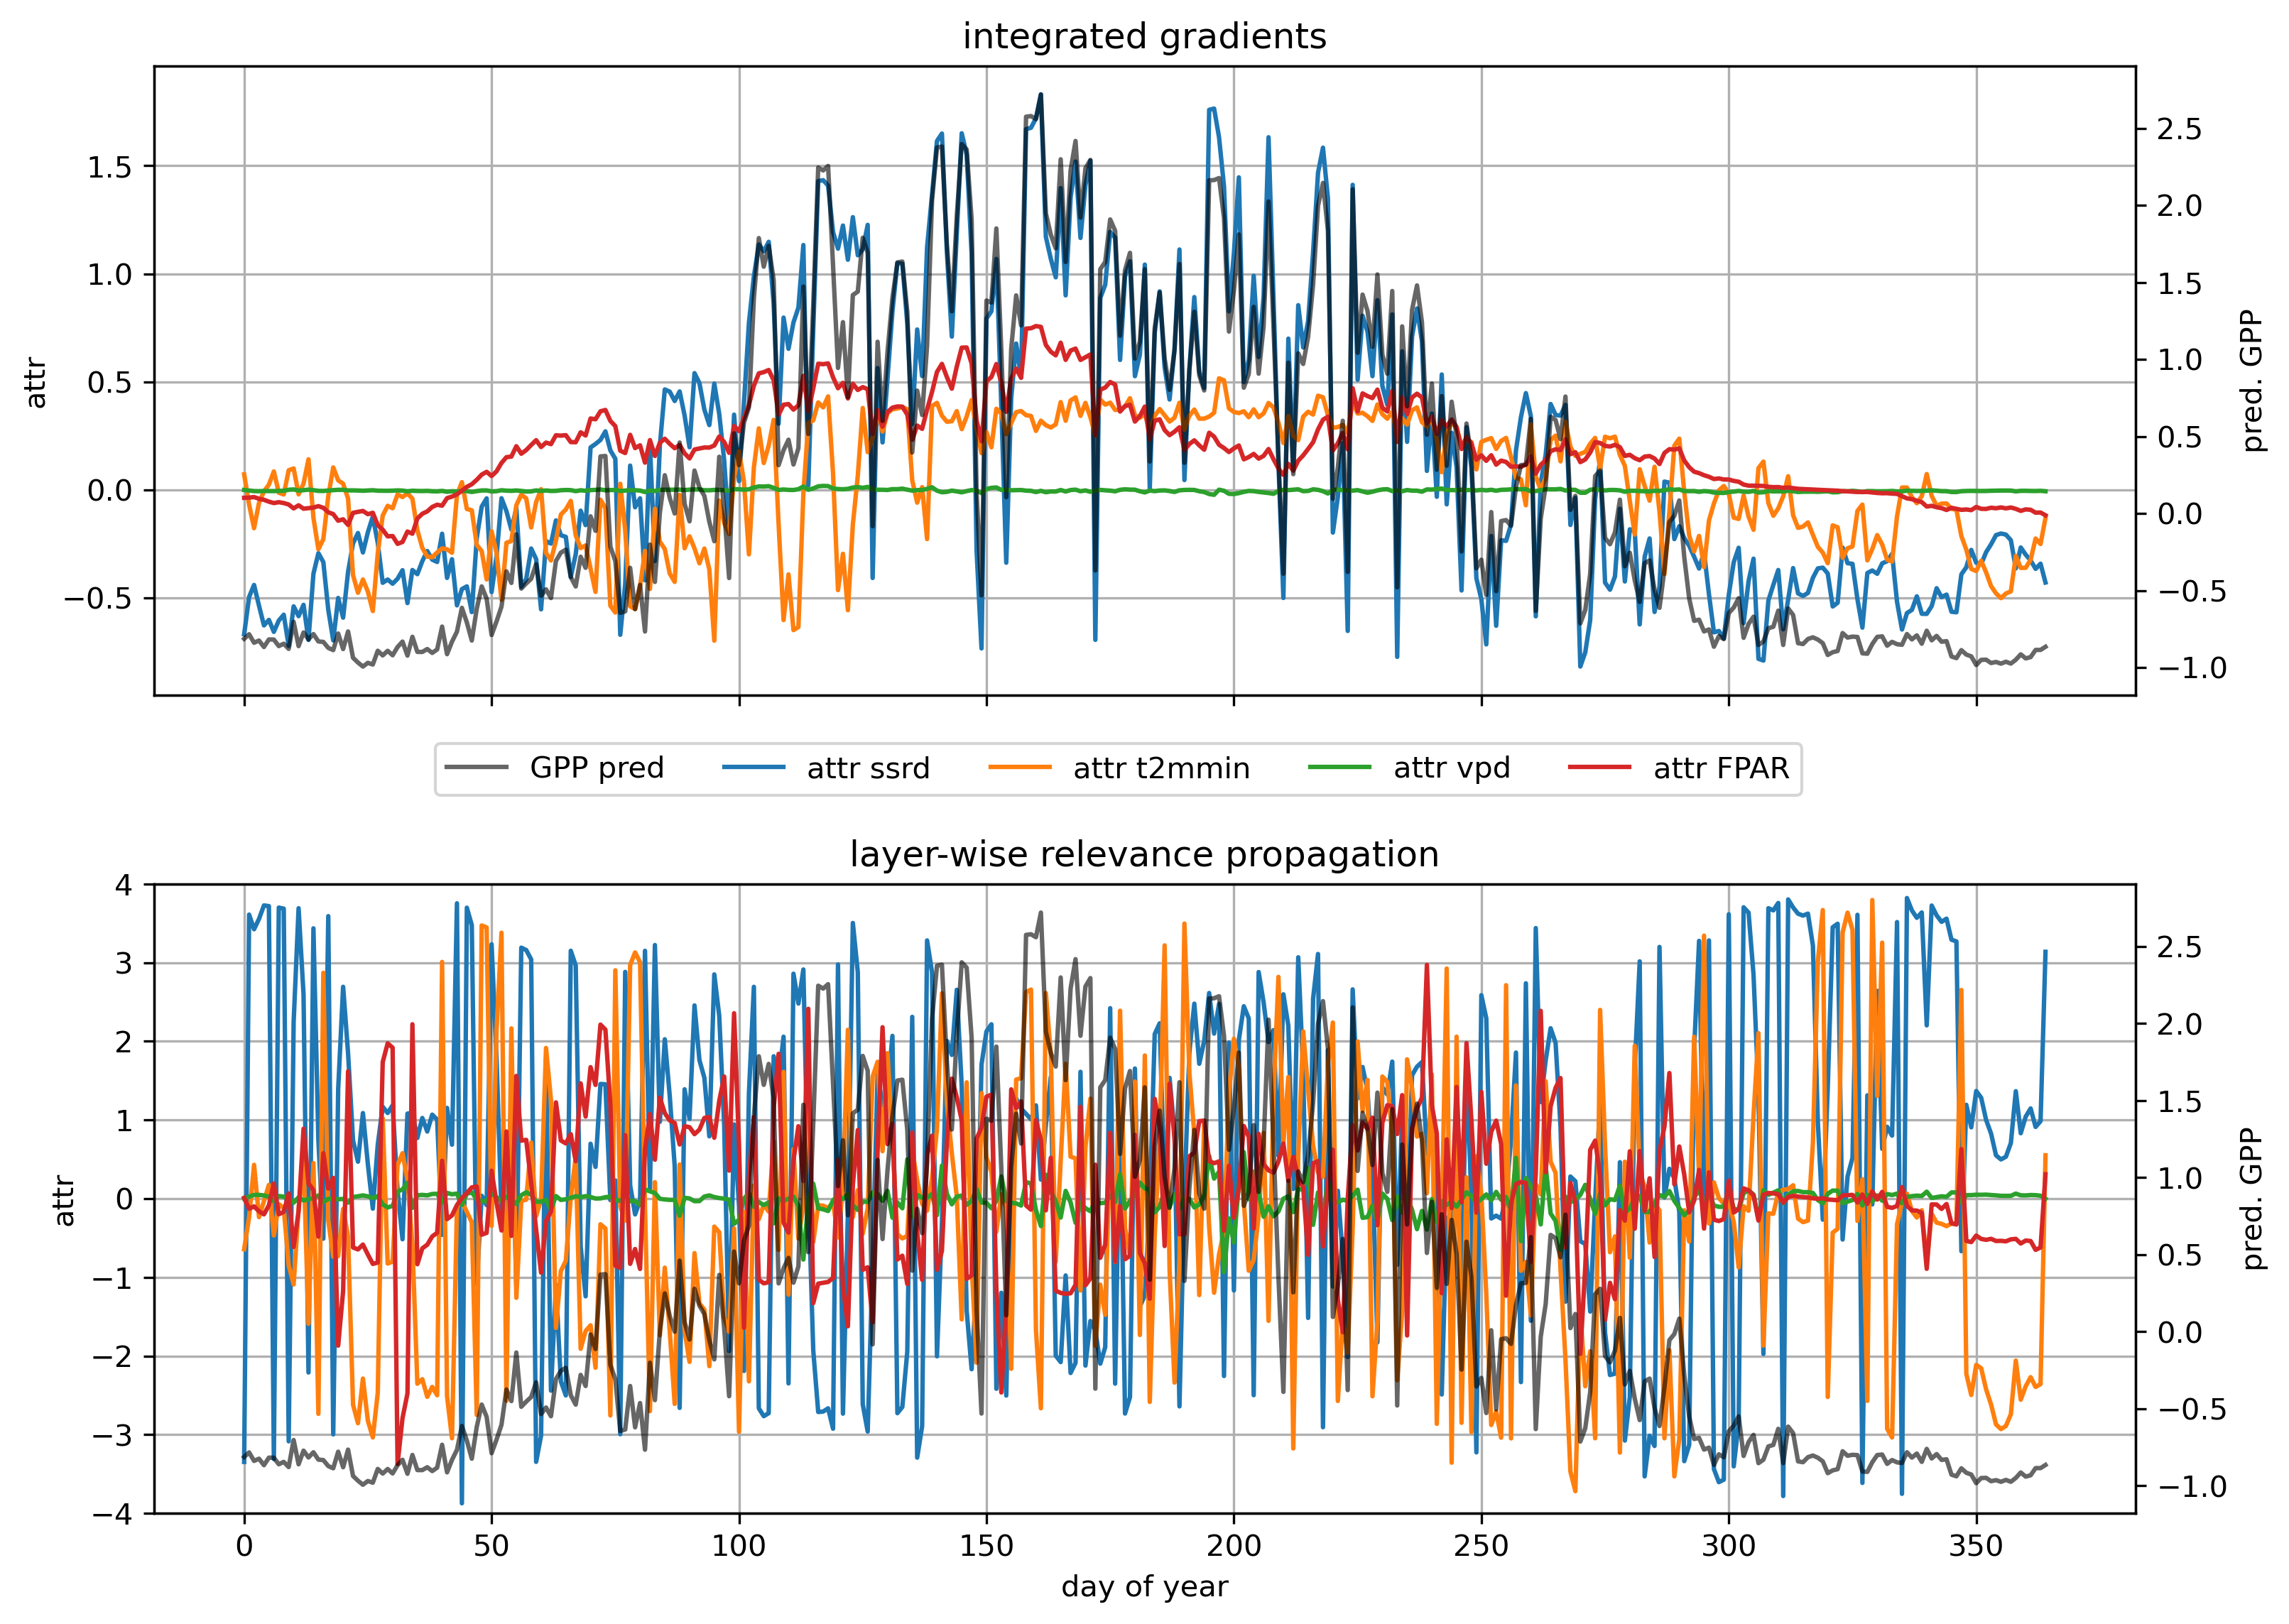

In [278]:
nth_year = 6
year_slice = slice(nth_year * 365, (nth_year + 1) * 365)

fig, axn = plt.subplots(2, 1, figsize=(12, 9), dpi=300, sharex='all')
axn[0].plot(intgrads[year_slice, :])

lines = axn[1].plot(lrp_attr_z[year_slice, :])
axn[1].set(ylim=(-4, 4))

for ax in axn:
    axt = ax.twinx()
    l = axt.plot(batch_y_hat.detach().squeeze()[year_slice], color='k', alpha=.6, zorder=-1)
    axt.set(ylabel='pred. GPP')

lines = [l[0], *lines]

for ax, title in zip(axn, ('integrated gradients', 'layer-wise relevance propagation')):
    ax.set(title=title, ylabel='attr')
    ax.grid(True)

fig.legend(lines, ['GPP pred', *['attr ' + l for l in valid_loader.dataset.features]], loc = (0.19, 0.51), ncol=5, fancybox=True, title=None)

axn[1].set(xlabel='day of year')

fig.subplots_adjust(hspace=.3)
plt.show()

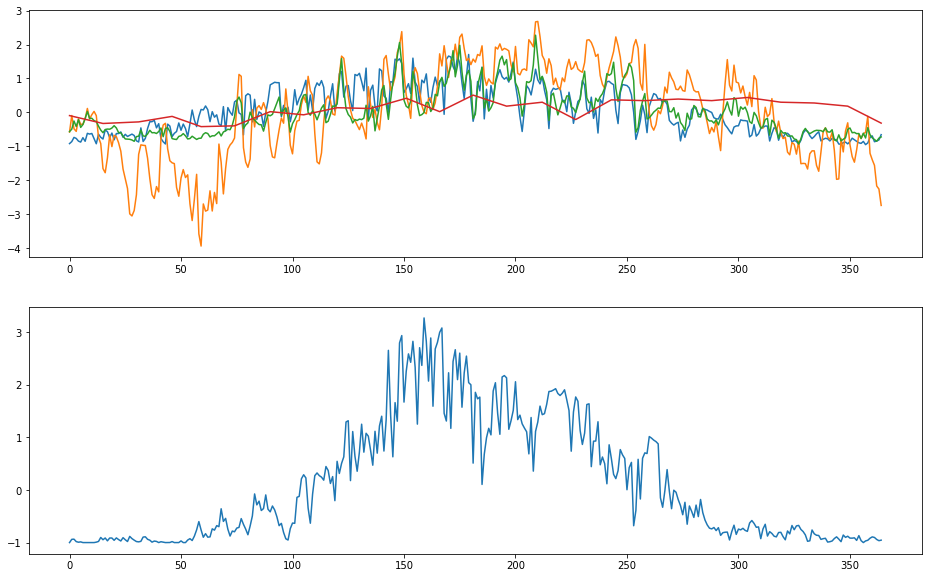

In [204]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(batch_x.detach().squeeze()[4 * 365:5 * 365, :])
axes[1].plot(batch_y.detach().squeeze()[2 * 365:3 * 365])
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(16, 10))

ax = axes[0]
ax2 = ax.twinx()
ax = ax.plot(intgrads[:365, 0], c='r', label='SWrad integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365, 0], c='b', label='SWrad')

ax = axes[1]
ax2 = ax.twinx()
ax.plot(intgrads[:365, 1], c='r', label='Tmin integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365, 1], c='b', label='Tmin')

ax = axes[2]
ax2 = ax.twinx()
ax.plot(intgrads[:365, 2], c='r', label='VPD integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365, 2], c='b', label='VPD')

ax = axes[3]
ax2 = ax.twinx()
ax.plot(intgrads[:365, 3], c='r', label='FPAR integrated gradients')
ax2.plot(batch_x.detach().squeeze()[:365, 3], c='b', label='FPAR')

axes[4].plot(batch_y_hat.detach().squeeze()[:365], label='GPP predicted')
axes[4].plot(batch_y.detach().squeeze()[:365], label='GPP')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].set_title('Normalized Predictors')
axes[0].plot(batch_x.detach().squeeze()[:365, :])
axes[0].legend(['SWrad', 'Tmin', 'VPD', 'FPAR'])

axes[1].set_title('Integrated Gradients')
axes[1].plot(intgrads[:365, :])
axes[1].legend(['SWrad', 'Tmin', 'VPD', 'FPAR'])

axes[2].set_title('Normalized Target: GPP')
axes[2].plot(batch_y_hat.detach().squeeze()[:365], label='Prediction')
axes[2].plot(batch_y.detach().squeeze()[:365], label='Pseudo Observation')
axes[2].legend()

axes[2].set_xlabel('Time, days')
plt.savefig('../plots/Integrated-Gradients_GPP_Teaser.png', dpi=300)

## Check correlation of target variable and predictor of interest

In [ ]:
sns.lmplot(data=df, x='vpd', y=target_var)
plt.show()

In [ ]:
r2 = df[['vpd', target_var]].corr().iloc[0, 1] ** 2

In [ ]:
print("R^2: " + str(round(r2, 2)))

Correlation is very high, although VPD is set to constant. Integrated gradients correctly could detect that VPD did not play a role in modelling GPP.

In [ ]:

lrp = LRP(model)
i = 0
lrp.attribute(batch_x[0, i, :], target=batch_y[0, i].unsqueeze(0))

ig = IG(model)

# for i in trange(n):
#     intgrds = compute_integrated_gradient(batch_x[0, i, :], batch_x_bl[0, i, :], model)
#     it, mn = intgrds
#     intgrads[i, :] = it

# attributions = ig.attribute((batch_x[0, i, :],),
#                             baselines=(batch_x_bl[0, i, :],), )